In [532]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from PIL import Image
from pathlib import Path
import os
import sys
from sklearn import linear_model
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In this notebook, we will explore the Yale Faces B data set's cropped and uncropped images, utilizing the SVD for dimensionality reduction and singular value analysis. Once we have reduced the dimension of the space for both the cropped and uncropped data sets, we move to classifying the cropped images using various supervised and unsupervised classification schemes present in the $\texttt{scikitlearn}$ toolbox. In particular, we use $k$-nearest neighbors to classify cropped faces according to individual identity and according to apparent gender identity; in each case we have solid success, depending on the number $k$ of nearest neighbors considered. Following this, we move to an unsupervised regime and use a $k$-means model and a Gaussian Mixture Model to again classify the cropped images.

In [46]:
path = "CroppedYale_condensed/"      #simply loading the data
dirs = os.listdir(path)
dirs.remove('.DS_Store')
dirs.sort()

data_folder = Path("CroppedYale_condensed/")

Bimages = np.zeros((192,168,len(dirs)))    #each CROPPED image is 192 x 168 pixels, with 2414 total photos


for ii in range(len(dirs)):
    img1 = data_folder / dirs[ii]
    img = open(img1)
    Bimages[:,:,ii] = Image.open(img1)

In [47]:
A = np.zeros((32256,len(dirs)))        

for ii in range(len(dirs)):
    A[:,ii] = np.reshape(Bimages[:,:,ii],32256)  #cropped images are reshaped into columns of the data matrix A
    
A = np.int16(A)

Now that we have our cropped images in the matrix $A$, we perform an SVD decomposition of $A$ in order to better understand the principal components of the data set; as expected, many of the 2414 singular values drop off in magnitude in comparison to the leading values, as illustrated in the semi-logscalse plot below.

In [48]:
U, S, V = np.linalg.svd(A, full_matrices=False) 

In [486]:
S.shape

(2414,)

Text(0.5, 0, 'Singular Values of Cropped, first 200')

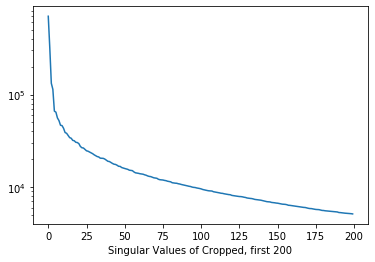

In [493]:
plt.rcParams['figure.figsize'] = [6, 4]

plt.semilogy(S[0:200])
plt.xlabel('Singular Values of Cropped, first 200')

With this curve in hand, we can be relatively confident that not too many dimensions should be needed for relatively accurate image reproduction; this is because the SVD has effectively given a route to express the images in a different basis than the standard basis. The columns of the matrix $U$ represent new basis vectors with which to express each of the images in such a way that as much information as possible is present in the dimensions corresponding to the singular values. These new basis vectors can be thought of as "eigenfaces" used to express the cropped faces, just as an eigenvector expansion serves to express vectors in the image of an invertible linear transformation.

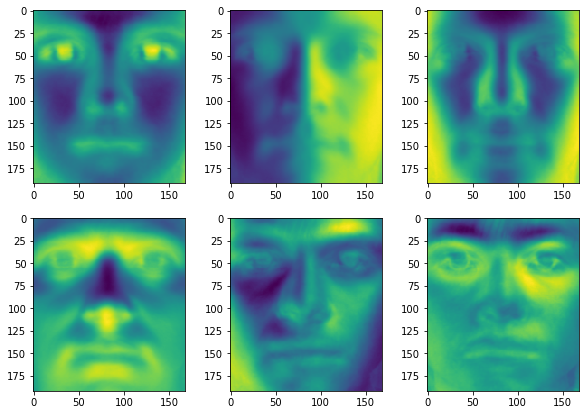

In [497]:
plt.rcParams['figure.figsize'] = [10, 7]

U0 = np.reshape(U[:,0],(192,168))
U1 = np.reshape(U[:,1],(192,168))
U2 = np.reshape(U[:,2],(192,168))
U3 = np.reshape(U[:,3],(192,168))
U4 = np.reshape(U[:,4],(192,168))
U5 = np.reshape(U[:,5],(192,168))

figs, axs = plt.subplots(2,3)

axs[0,0].imshow(U0)
axs[0,1].imshow(U1)
axs[0,2].imshow(U2)
axs[1,0].imshow(U3)
axs[1,1].imshow(U4)
axs[1,2].imshow(U5)

We now move on to creating reduced-rank approximations to $A$ by truncating the SVD according to several benchmarks deemed reasonable after considering the above; we employ rank 10, 25, 50, 100, and 125 approximations, considering in each case the quality of the image reproduction.

In [185]:
U10 = U[:,0:10] ; S10 = np.diag(S[0:10]) ; V10 = V[0:10,:]
U25 = U[:,0:25] ; S25 = np.diag(S[0:25]) ; V25 = V[0:25,:]
U50 = U[:,0:50] ; S50 = np.diag(S[0:50]) ; V50 = V[0:50,:]              #rank r approximations
U100 = U[:,0:100] ; S100 = np.diag(S[0:100]) ; V100 = V[0:100,:]
U125 = U[:,0:125] ; S125 = np.diag(S[0:125]) ; V125 = V[0:125,:]

In [186]:
A10 = U10 @ S10 @ V10
A25 = U25 @ S25 @ V25          #recreating images using rank r approximations
A50 = U50 @ S50 @ V50
A100 = U100 @ S100 @ V100
A125 = U125 @ S125 @ V125

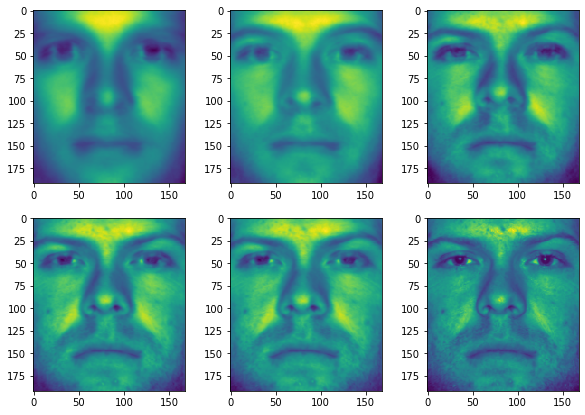

In [482]:
plt.rcParams['figure.figsize'] = [10, 7]

A10_0 = np.reshape(A10[:,0],(192,168))
A25_0 = np.reshape(A25[:,0],(192,168))
A50_0 = np.reshape(A50[:,0],(192,168))
A100_0 = np.reshape(A100[:,0],(192,168))
A125_0 = np.reshape(A125[:,0],(192,168))

figs, axs = plt.subplots(2,3)

axs[0,0].imshow(A10_0)
axs[0,1].imshow(A25_0)
axs[0,2].imshow(A50_0)
axs[1,0].imshow(A100_0)
axs[1,1].imshow(A125_0)
axs[1,2].imshow(np.reshape(A[:,0],(192,168)))

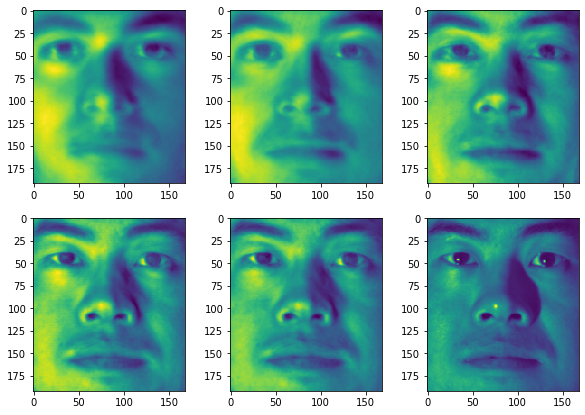

In [485]:
plt.rcParams['figure.figsize'] = [10, 7]

A10_82 = np.reshape(A10[:,82],(192,168))
A25_82 = np.reshape(A25[:,82],(192,168))
A50_82 = np.reshape(A50[:,82],(192,168))
A100_82 = np.reshape(A100[:,82],(192,168))
A125_82 = np.reshape(A125[:,82],(192,168))

figs, axs = plt.subplots(2,3)

axs[0,0].imshow(A10_82)
axs[0,1].imshow(A25_82)
axs[0,2].imshow(A50_82)
axs[1,0].imshow(A100_82)
axs[1,1].imshow(A125_82)
axs[1,2].imshow(np.reshape(A[:,82],(192,168)))

After considering each of the above two photos (the 1st and 83rd in the cropped images data set), we see that solid reproductions are obtained using even the rank 50 approximations, but rank 100 and 125 approximations also perform well. In the sequel, we will use rank 50 and 100 approximations as the basis for our classification analysis.

Before beginning our classification schemes, we consider the uncropped images using the same approach as above; as expected, the uncropped data set appears to be more unwieldy than the cropped.

In [22]:
path = "yalefaces/"
dirs = os.listdir(path)

data_folder = Path("yalefaces/")      #loading uncropped images

Bigimages = np.zeros((243,320,len(dirs)))     #there are 165 uncropped images, each with 243 x 320 pixels

for ii in range(len(dirs)):
    img1 = data_folder / dirs[ii]
    Bigimages[:,:,ii] = Image.open(img1)

In [23]:
B = np.zeros((77760,len(dirs)))     #as before, uncropped images are unraveled into columns, which will comprise 
                                    #a matrix B of uncropped data having 165 columns
for ii in range(len(dirs)):
    B[:,ii] = np.reshape(Bigimages[:,:,ii],77760)
    
B = np.int16(B)

In [24]:
Ub, Sb, Vb = np.linalg.svd(B,full_matrices=False)

Text(0.5, 0, 'Singular Values of Uncropped')

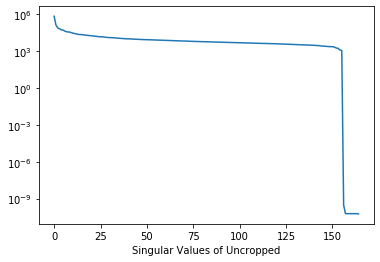

In [496]:
plt.semilogy(Sb[0:200])
plt.xlabel('Singular Values of Uncropped')

[Text(0.5, 0, 'Singular Values of Uncropped')]

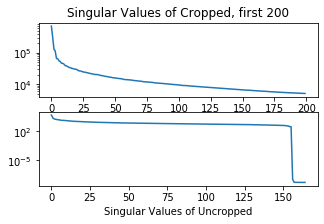

In [665]:
plt.rcParams['figure.figsize'] = [5,3]
fig, axs = plt.subplots(2,1)
axs[0].plot(S[0:200])
axs[0].set_yscale('log')
axs[0].title.set_text('Singular Values of Cropped, first 200')
axs[1].plot(Sb[0:200])
axs[1].set_yscale('log')
axs[1].set(xlabel='Singular Values of Uncropped')

The difficulty of working with uncropped images is already direcly apparent; of the 165 SVD modes, around 150 of them are of comparable nontrivial magnitude. As is classically the case, the magnitude of the singular values drops quickly at first, but here we notice a distinct plateau that persists for much of the range from value 25 to value 130 or so; this behavior is indicative that there are many more modes that must be considered than for the cropped images. Additional processing (such as edge identification) would likely lead to dimensionality reduction for this case, but as it stands the data will be harder to work with (per photo) than the cropped images. 

As before, we consider the first 6 "eigenfaces" used as the basis vectors for the SVD representation of the uncropped data.

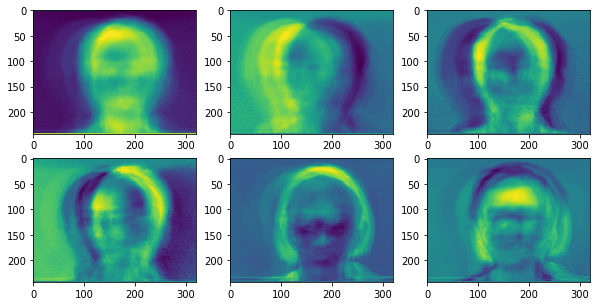

In [501]:
plt.rcParams['figure.figsize'] = [10, 5]

Ub0 = np.reshape(Ub[:,0],(243,320))
Ub1 = np.reshape(Ub[:,1],(243,320))
Ub2 = np.reshape(Ub[:,2],(243,320))
Ub3 = np.reshape(Ub[:,3],(243,320))
Ub4 = np.reshape(Ub[:,4],(243,320))
Ub5 = np.reshape(Ub[:,5],(243,320))

figs, axs = plt.subplots(2,3)

axs[0,0].imshow(Ub0)
axs[0,1].imshow(Ub1)
axs[0,2].imshow(Ub2)
axs[1,0].imshow(Ub3)
axs[1,1].imshow(Ub4)
axs[1,2].imshow(Ub5)

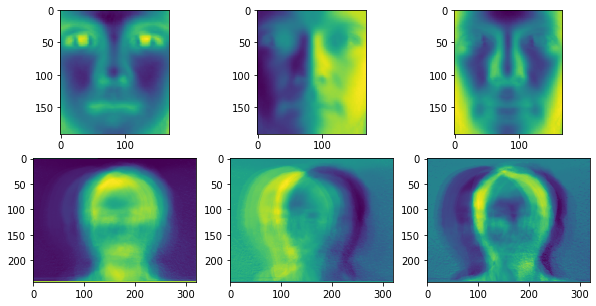

In [651]:
plt.rcParams['figure.figsize'] = [10, 5]

figs, axs = plt.subplots(2,3)

axs[1,0].imshow(Ub0)
axs[1,1].imshow(Ub1)
axs[1,2].imshow(Ub2)
axs[0,0].imshow(U0)
axs[0,1].imshow(U1)
axs[0,2].imshow(U2)


It is immediately apparent that the eigenfaces for the uncropped photos are more vague than those of the cropped photos. In particular, note that in each eigenface for the unfropped photos we have several head-shaped outlines; this is because the eigenfaces must be used for much more than simply facial feature recognition, needing also to establish where the distinct outlines of the faces are in each of the images.

WE now move on to the low-rank approximations of faces in the uncropped image set. At the outset we note that we should not be $\textit{too}$ confident about the low-rank results, as the singular value spectrum does not inspire great faith in the ability of only a few dimensions to capture the images. 

In [35]:
Ub10 = Ub[:,0:10] ; Sb10 = np.diag(Sb[0:10]) ; Vb10 = Vb[0:10,:]
Ub25 = Ub[:,0:25] ; Sb25 = np.diag(Sb[0:25]) ; Vb25 = Vb[0:25,:]
Ub50 = Ub[:,0:50] ; Sb50 = np.diag(Sb[0:50]) ; Vb50 = Vb[0:50,:]   #lower-rank approximations to the SVD factors
Ub100 = Ub[:,0:100] ; Sb100 = np.diag(Sb[0:100]) ; Vb100 = Vb[0:100,:]
Ub125 = Ub[:,0:125] ; Sb125 = np.diag(Sb[0:125]) ; Vb100 = Vb[0:100,:]

In [36]:
B10 = Ub10 @ Sb10 @ Vb10
B25 = Ub25 @ Sb25 @ Vb25
B50 = Ub50 @ Sb50 @ Vb50
B100 = Ub100 @ Sb100 @ Vb100         #lower-rank approximation of the matrix B of uncropped images
B125 = Ub125 @ Sb125 @ Vb125

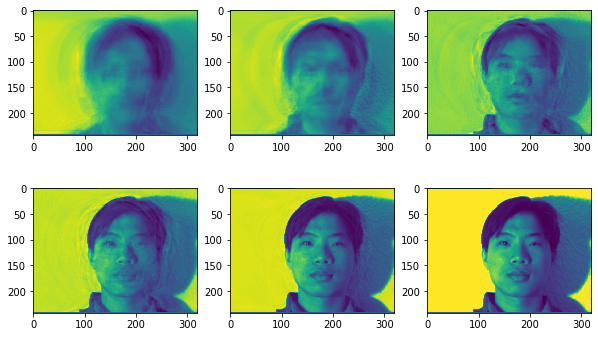

In [484]:
plt.rcParams['figure.figsize'] = [10, 5]

B10_0 = np.reshape(B10[:,0],(243,320))
B25_0 = np.reshape(B25[:,0],(243,320))
B50_0 = np.reshape(B50[:,0],(243,320))
B100_0 = np.reshape(B100[:,0],(243,320))
B125_0 = np.reshape(B125[:,0],(243,320))

fig, axs = plt.subplots(2,3)

axs[0,0].imshow(B10_0)
axs[0,1].imshow(B25_0)
axs[0,2].imshow(B50_0)
axs[1,0].imshow(B100_0)
axs[1,1].imshow(B125_0)
axs[1,2].imshow(np.reshape(B[:,0],(243,320)))

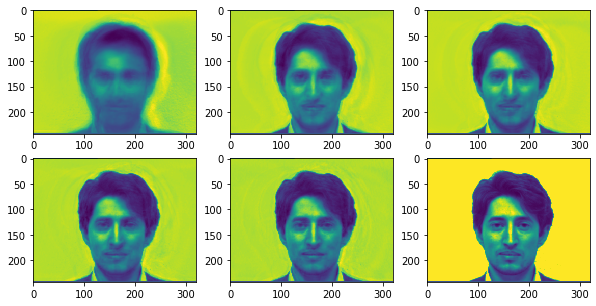

In [531]:
plt.rcParams['figure.figsize'] = [10, 5]

B10_20 = np.reshape(B10[:,20],(243,320))
B25_20 = np.reshape(B25[:,20],(243,320))
B50_20 = np.reshape(B50[:,20],(243,320))
B100_20 = np.reshape(B100[:,20],(243,320))
B125_20 = np.reshape(B125[:,20],(243,320))

fig, axs = plt.subplots(2,3)

axs[0,0].imshow(B10_20)
axs[0,1].imshow(B25_20)
axs[0,2].imshow(B50_20)
axs[1,0].imshow(B100_20)
axs[1,1].imshow(B125_20)
axs[1,2].imshow(np.reshape(B[:,20],(243,320)))

Just as we expect from considering the Singular Value spectrum, the low-rank approximations of uncropped images do not perform as well in comparison to the true images. Since the singular values are much more densely distributed nearer to the magnitude of the first singular value, there is simply too much information lost in the eliminated dimensions for the rank 10, 25, or 50 approximations to be considered accurate reproductions of the faces portrayed. 

Now, with our present understanding of the ranks needed for accurately representing the cropped images, we move on to the classification tasks. For classifying, we will use the $k$-nearest neighbors supervised classification scheme with several values of $k$ to get a sense of which number of neighbors should be considered for optimal identification of identity and of (apparent) gender. Following this supervised scheme, we use the unsupervised models of Gaussian Mixture and $k$-means to attempt to find existing patterns in the images themselves. 

To begin, we create the labels used in the supervised classification.

In [146]:
Lwho = np.zeros(2414)        #making individual labels, naming them 1 - 38 based on the names of their folders

for ii in range(10):
    Lwho[ii*64:ii*64+64] = ii*np.ones(64)

Lwho[640:700] = 11*np.ones(60)
Lwho[700:759] = 12*np.ones(59)
Lwho[759:819] = 13*np.ones(60)
Lwho[819:882] = 14*np.ones(63)
Lwho[882:944] = 15*np.ones(62)
Lwho[944:1007] = 16*np.ones(63)
Lwho[1007:1070] = 17*np.ones(63)

for jj in range(21):
    Lwho[1070+jj*64:1070+jj*64+64] = (jj + 18)*np.ones(64)

In [176]:
Lgen = np.zeros(2414)             #making gender labels

Lgen[0:64] = 1*np.ones(64)   #1
Lgen[64:128] = 1*np.ones(64)
Lgen[128:192] = 1*np.ones(64)
Lgen[192:256] = 1*np.ones(64)
Lgen[256:320] = 2*np.ones(64)   #5
Lgen[320:384] = 1*np.ones(64)
Lgen[384:448] = 1*np.ones(64)
Lgen[448:512] = 1*np.ones(64)
Lgen[512:576] = 1*np.ones(64)
Lgen[576:640] = 1*np.ones(64)  #10
Lgen[640:700] = 1*np.ones(60)
Lgen[700:759] = 1*np.ones(59)
Lgen[759:819] = 1*np.ones(60)  #13
Lgen[819:882] = 2*np.ones(63)  #15
Lgen[882:944] = 1*np.ones(62)  
Lgen[944:1007] = 1*np.ones(63)
Lgen[1007:1070] = 1*np.ones(63)
Lgen[1070:1134] = 1*np.ones(64)
Lgen[1134:1198] = 1*np.ones(64) #20
Lgen[1198:1262] = 1*np.ones(64)
Lgen[1262:1326] = 2*np.ones(64)
Lgen[1326:1390] = 1*np.ones(64)
Lgen[1390:1454] = 1*np.ones(64)
Lgen[1454:1518] = 1*np.ones(64) #25
Lgen[1518:1582] = 1*np.ones(64)
Lgen[1582:1646] = 2*np.ones(64)
Lgen[1646:1710] = 2*np.ones(64)
Lgen[1710:1774] = 1*np.ones(64)
Lgen[1774:1838] = 1*np.ones(64) #30
Lgen[1838:1902] = 1*np.ones(64)
Lgen[1902:1966] = 2*np.ones(64)
Lgen[1966:2030] = 1*np.ones(64)
Lgen[2030:2094] = 1*np.ones(64)
Lgen[2094:2158] = 1*np.ones(64) #35
Lgen[2158:2222] = 1*np.ones(64)
Lgen[2222:2286] = 2*np.ones(64)
Lgen[2286:2350] = 1*np.ones(64)
Lgen[2350:2414] = 1*np.ones(64) #39

At present, the data in the reduced-rank matrices $\texttt{V50}$ and $\texttt{V100}$ are ordered linearly according to the order in which the individuals' photos were condensed into the folders present in the original data set. Because of this, we cannot simply cutoff at some value and have all training before and all testing after, as this would necessarily miss seome of the individuals in the training data. In an attempt to get around this, we apply a random permutation to the columns of the matrices $\texttt{V50}$ and $\texttt{V100}$ before dividing the columns into the forst 1500 and last 914 for training and testing, respectively. This approach has the added benefit of being easily generalized for cross-validation purposes (applying different random permutations and re-checking results "from another perspective").

In [567]:
P = np.random.permutation(2414)

In [568]:
Xtr100 = np.zeros((1500,100))       #training X to be used, rank 100 approximation
for ii in range(1500):
    Xtr100[ii,:] = V100[:,P[ii]]
Xte100 = np.zeros((914,100))        #testing X to be used, rank 100 approximation
for ii in range(914):
    Xte100[ii,:] = V100[:,P[1500+ii]]
    
    
Bgtr100 = np.zeros((1500))     #B side of Ax=B, training, gender decision
for ii in range(1500):
    Bgtr100[ii] = Lgen[P[ii]]   
Bgte100 = np.zeros((914))     #B side of Ax=B, testing, gender decision
for ii in range(914):
    Bgte100[ii] = Lgen[P[1500+ii]]
    
    
Bwtr100 = np.zeros((1500))     #B side of Ax=B, training, individual identification
for ii in range(1500):
    Bwtr100[ii] = Lwho[P[ii]]  
Bwte100 = np.zeros((914))     #B side of Ax=B, testing, individual identification
for ii in range(914):
    Bwte100[ii] = Lwho[P[1500+ii]]    

In [569]:
Xtr50 = np.zeros((1500,50))       #training X to be used, rank 50 approximation
for ii in range(1500):
    Xtr50[ii,:] = V50[:,P[ii]]
Xte50 = np.zeros((914,50))        #testing X to be used, rank 50 approximation
for ii in range(914):
    Xte50[ii,:] = V50[:,P[1500+ii]]
    
    
Bgtr50 = np.zeros((1500))     #B side of Ax=B, training, gender decision
for ii in range(1500):
    Bgtr50[ii] = Lgen[P[ii]]
Bgte50 = np.zeros((914))     #B side of Ax=B, testing, gender decision
for ii in range(914):
    Bgte50[ii] = Lgen[P[1500+ii]]
    
    
Bwtr50 = np.zeros((1500))     #B side of Ax=B, training, individual identification
for ii in range(1500):
    Bwtr50[ii] = Lwho[P[ii]]  
Bwte50 = np.zeros((914))     #B side of Ax=B, testing, individual identification
for ii in range(914):
    Bwte50[ii] = Lwho[P[1500+ii]]  

We now proceed to training and testing the $K$-Nearest Neighbors classification method imported from $\texttt{scikitlearn}$. To do this, we take each of the rank 100 and 50 approximations and train on the corresponding part of the data set. Once this is done, we test on the remaining data ($\texttt{Xte50}$ and $\texttt{Xte100}$) and measure the error in two ways: first, we simply count up the number of times that the model predicts a label different from the correct label; second, we compute the score using the $\texttt{score}$ attribute present in the $\texttt{scikitlearn}$ library.

In [611]:
neigh = KNeighborsClassifier(1)     #single nearest neighbor, rank 100, individual identification
neigh.fit(Xtr100,Bwtr100)
PredWho = neigh.predict(Xte100)
PredWho = np.round(PredWho)

KNNerrWho = 0     #KNNerrWho will track the number of times the PredWho predictions guess incorrectly
for ii in range(914):
    if Bwte100[ii] != PredWho[ii]:
        KNNerrWho = KNNerrWho + 1     #tick up once each time the label is incorrect
print(KNNerrWho)
print(neigh.score(Xte100,Bwte100))   #score function in scikitlearn, which records avg accuracy of prediction

80
0.912472647702407


In [613]:
neigh = KNeighborsClassifier(3)     #three nearest neighbors, rank 100, individual identification
neigh.fit(Xtr100,Bwtr100)
PredWho = neigh.predict(Xte100)
PredWho = np.round(PredWho)
KNNerrWho = 0
for ii in range(914):
    if Bwte100[ii] != PredWho[ii]:
        KNNerrWho = KNNerrWho + 1
print(KNNerrWho)
print(neigh.score(Xte100,Bwte100))

103
0.887308533916849


In [614]:
neigh = KNeighborsClassifier(5)     #five nearest neighbors, rank 100, individual identification
neigh.fit(Xtr100,Bwtr100)
PredWho = neigh.predict(Xte100)
PredWho = np.round(PredWho)
KNNerrWho = 0
for ii in range(914):
    if Bwte100[ii] != PredWho[ii]:
        KNNerrWho = KNNerrWho + 1
print(KNNerrWho)
print(neigh.score(Xte100,Bwte100))

104
0.8862144420131292


In [615]:
neigh = KNeighborsClassifier(1)     #single nearest neighbor, rank 100, gender identification
neigh.fit(Xtr100,Bgtr100)
PredGen = neigh.predict(Xte100)
PredGen = np.round(PredGen)
KNNerrGen = 0
for ii in range(914):
    if Bgte100[ii] != PredGen[ii]:
        KNNerrGen = KNNerrGen + 1
print(KNNerrGen)
print(neigh.score(Xte100,Bgte100))

17
0.9814004376367614


In [620]:
neigh = KNeighborsClassifier(3)     #three nearest neighbors, rank 100, gender identification
neigh.fit(Xtr100,Bgtr100)
PredGen = neigh.predict(Xte100)
PredGen = np.round(PredGen)
KNNerrGen = 0
for ii in range(914):
    if Bgte100[ii] != PredGen[ii]:
        KNNerrGen = KNNerrGen + 1
print(KNNerrGen)
print(neigh.score(Xte100,Bgte100))

19
0.9792122538293216


In [621]:
neigh = KNeighborsClassifier(5)     #five nearest neighbors, rank 100, gender identification
neigh.fit(Xtr100,Bgtr100)
PredGen = neigh.predict(Xte100)
PredGen = np.round(PredGen)
KNNerrGen = 0
for ii in range(914):
    if Bgte100[ii] != PredGen[ii]:
        KNNerrGen = KNNerrGen + 1
print(KNNerrGen)
print(neigh.score(Xte100,Bgte100))

24
0.973741794310722


In [622]:
neigh = KNeighborsClassifier(1)     #single nearest neighbor, rank 50, individual identification
neigh.fit(Xtr50,Bwtr50)
PredWho = neigh.predict(Xte50)
PredWho = np.round(PredWho)

KNNerrWho = 0     #KNNerrWho will track the number of times the PredWho predictions guess incorrectly
for ii in range(914):
    if Bwte50[ii] != PredWho[ii]:
        KNNerrWho = KNNerrWho + 1     #tick up once each time the label is incorrect
print(KNNerrWho)
print(neigh.score(Xte50,Bwte50))   #score function in scikitlearn, which records avg accuracy of prediction

147
0.8391684901531729


In [624]:
neigh = KNeighborsClassifier(3)     #three nearest neighbors, rank 50, individual identification
neigh.fit(Xtr50,Bwtr50)
PredWho = neigh.predict(Xte50)
PredWho = np.round(PredWho)
KNNerrWho = 0
for ii in range(914):
    if Bwte50[ii] != PredWho[ii]:
        KNNerrWho = KNNerrWho + 1
print(KNNerrWho)
print(neigh.score(Xte50,Bwte50))

146
0.8402625820568927


In [626]:
neigh = KNeighborsClassifier(5)     #five nearest neighbors, rank 50, individual identification
neigh.fit(Xtr50,Bwtr50)
PredWho = neigh.predict(Xte50)
PredWho = np.round(PredWho)
KNNerrWho = 0
for ii in range(914):
    if Bwte50[ii] != PredWho[ii]:
        KNNerrWho = KNNerrWho + 1
print(KNNerrWho)
print(neigh.score(Xte50,Bwte50))

153
0.8326039387308534


In [627]:
neigh = KNeighborsClassifier(1)     #single nearest neighbor, rank 50, gender identification
neigh.fit(Xtr50,Bgtr50)
PredGen = neigh.predict(Xte50)
PredGen = np.round(PredGen)
KNNerrGen = 0
for ii in range(914):
    if Bgte50[ii] != PredGen[ii]:
        KNNerrGen = KNNerrGen + 1
print(KNNerrGen)
print(neigh.score(Xte50,Bgte50))

29
0.9682713347921226


In [628]:
neigh = KNeighborsClassifier(3)     #three nearest neighbors, rank 50, gender identification
neigh.fit(Xtr50,Bgtr50)
PredGen = neigh.predict(Xte50)
PredGen = np.round(PredGen)
KNNerrGen = 0
for ii in range(914):
    if Bgte50[ii] != PredGen[ii]:
        KNNerrGen = KNNerrGen + 1
print(KNNerrGen)
print(neigh.score(Xte50,Bgte50))

28
0.9693654266958425


In [629]:
neigh = KNeighborsClassifier(5)     #five nearest neighbors, rank 50, gender identification
neigh.fit(Xtr50,Bgtr50)
PredGen = neigh.predict(Xte50)
PredGen = np.round(PredGen)
KNNerrGen = 0
for ii in range(914):
    if Bgte50[ii] != PredGen[ii]:
        KNNerrGen = KNNerrGen + 1
print(KNNerrGen)
print(neigh.score(Xte50,Bgte50))

32
0.9649890590809628


We now reiterate the above process, using cross-validation and iterative score-checking to assure us that our analysis is not biased based on the images used to train. This cross-validation procedure takes 5 random permutations of the 2414 cropped images in place of the single permutation used above. In the case of each fo the 5 permutations, the data is permuted and then divided into training and testing pieces as before, training on the first 1500 permuted images and testing on the remining 914. After a model is obtained for each of the "Who?" and "Gender?" questions for a given permutation, we compute the score of each model. After all 5 permutations are considered, we compute the average score on each of the "Who?" and "Gender?" questions.

The process described here is performed for both the rank 100 and the rank 50 approximations, achieving good average scores for both.

In [550]:
P = np.zeros((2414,5))
for kk in range(5):
    P[:,kk] = np.random.permutation(2414)
P = P.astype(int)

score100who = 0
score100gen = 0
for jj in range(5):

    Xtr100 = np.zeros((1500,100))       #training X to be used, rank 100 approximation
    for ii in range(1500):
        Xtr100[ii,:] = V100[:,P[ii,jj]]
    Xte100 = np.zeros((914,100))        #testing X to be used, rank 100 approximation
    for ii in range(914):
        Xte100[ii,:] = V100[:,P[1500+ii,jj]]
    
    
    Bgtr100 = np.zeros((1500))     #B side of Ax=B, training, gender decision
    for ii in range(1500):
        Bgtr100[ii] = Lgen[P[ii,jj]]   
    Bgte100 = np.zeros((914))     #B side of Ax=B, testing, gender decision
    for ii in range(914):
        Bgte100[ii] = Lgen[P[1500+ii,jj]]
    
    
    Bwtr100 = np.zeros((1500))     #B side of Ax=B, training, individual identification
    for ii in range(1500):
        Bwtr100[ii] = Lwho[P[ii,jj]]  
    Bwte100 = np.zeros((914))     #B side of Ax=B, testing, individual identification
    for ii in range(914):
        Bwte100[ii] = Lwho[P[1500+ii,jj]]  
        
    neigh = KNeighborsClassifier(3)
    neigh.fit(Xtr100,Bgtr100)

    score100gen = score100gen + neigh.score(Xte100,Bgte100)
    
    neigh = KNeighborsClassifier(3)
    neigh.fit(Xtr100,Bwtr100)

    score100who = score100who + neigh.score(Xte100,Bwte100)
    
score100who = 0.2*score100who
score100gen = 0.2*score100gen
print(score100who)
print(score100gen)

0.8704595185995624
0.9678336980306347


In [576]:
P = np.zeros((2414,5))
for kk in range(5):
    P[:,kk] = np.random.permutation(2414)
P = P.astype(int)

score50who = 0
score50gen = 0
for jj in range(5):

    Xt50 = np.zeros((1500,50))       #training X to be used, rank 50 approximation
    for ii in range(1500):
        Xtr50[ii,:] = V50[:,P[ii,jj]]
    Xte50 = np.zeros((914,50))        #testing X to be used, rank 50 approximation
    for ii in range(914):
        Xte50[ii,:] = V50[:,P[1500+ii,jj]]
    
    
    Bgtr50 = np.zeros((1500))     #B side of Ax=B, training, gender decision
    for ii in range(1500):
        Bgtr50[ii] = Lgen[P[ii,jj]]   
    Bgte50 = np.zeros((914))     #B side of Ax=B, testing, gender decision
    for ii in range(914):
        Bgte50[ii] = Lgen[P[1500+ii,jj]]
    
    
    Bwtr50 = np.zeros((1500))     #B side of Ax=B, training, individual identification
    for ii in range(1500):
        Bwtr50[ii] = Lwho[P[ii,jj]]  
    Bwte50 = np.zeros((914))     #B side of Ax=B, testing, individual identification
    for ii in range(914):
        Bwte50[ii] = Lwho[P[1500+ii,jj]]  
        
    neigh = KNeighborsClassifier(3)
    neigh.fit(Xtr50,Bgtr50)

    score50gen = score50gen + neigh.score(Xte50,Bgte50)
    
    neigh = KNeighborsClassifier(3)
    neigh.fit(Xtr50,Bwtr50)

    score50who = score50who + neigh.score(Xte50,Bwte50)
    
score50who = 0.2*score50who
score50gen = 0.2*score50gen
print(score50who)
print(score50gen)

0.8461706783369805
0.97417943107221


As can be seen above via the highly favorable scores even after cross-validation, the $k$-nearest neighbor method with 3 nearest neighbors performs quite well in both rank 50 and rank 100 schemes when asked either to identify individuals or to identify the apparent gender of the individuals portrayed. In particular, for rank 100 we see roughly 87% accuracy in individual identification with 96.8% accuracy in gender classification; for rank 50 the results are similar, with 84.6% accuracy in individual identify verification and 97.4% accuracy in gender classification. These findings suggest that rank 100 is perhaps even overkill for answering these kinds of questions about this data set.

We move on now to the unsupervised classification portion of the assignment. Here we use two standard unsupervised algorithms to attempt to classify the given data into various numbers of bins; the algorithms used are the Gaussian Mixture Model and the $k$-means process, both of which are standard in the data science community. Each of these is employed here via the $\texttt{scikitlearn}$ Python library. 

We first consider the Gaussian Mixture Models before moving on to the $k$-means Models. 

198.3104306653282


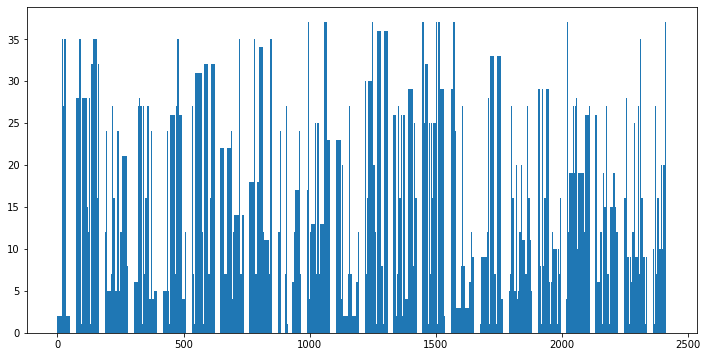

In [648]:
plt.rcParams['figure.figsize'] = [12, 6]   #checking architecture of the process

model = GaussianMixture(38)
GMM = model.fit_predict(V100.T)  #unsupervised, so we look for clusters in the entire rank 50 data set
plt.bar(np.arange(2414),GMM)

print(model.score(V100.T))

We now use the present architecture iteratively, checking and re-checking the plots to see if the GMM algorithm consistently discovers any particular patterns in the data set; if on 6 iterations of model construction the label distributions have a degree of similarity across them, we can conclude that the patterns represented by the common labeling schemes are actually present in the data, rather than simply being an artifact of the procedure.

270.3525890158343


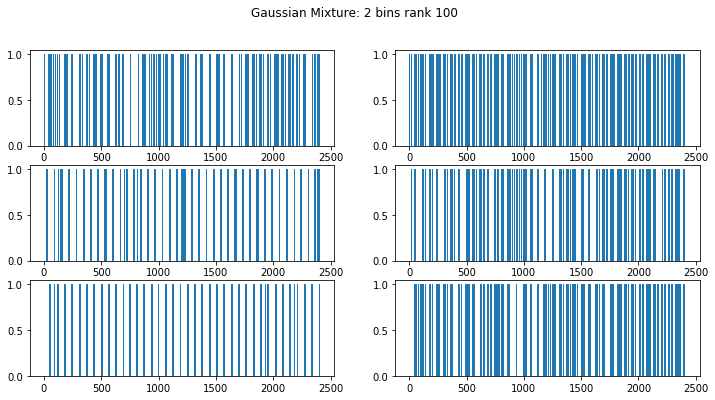

In [605]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 2 bins rank 100')
ScoreGMM100 = 0
                                               #six plots, 2 bins GMM rank 100
for ii in range(3):
    model = GaussianMixture(2)
    GMM = model.fit_predict(V100.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM50 + model.score(V100.T)
    
    model = GaussianMixture(2)
    GMM = model.fit_predict(V100.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)

ScoreGMM100 = (1/6)*ScoreGMM100
print(ScoreGMM100)

289.8033477342463


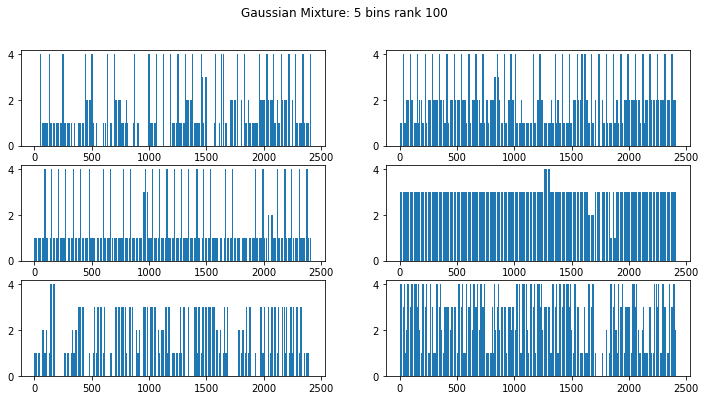

In [666]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 5 bins rank 100')
ScoreGMM100 = 0
                                               #six plots, 5 bins GMM rank 100

for ii in range(3):
    model = GaussianMixture(5)
    GMM = model.fit_predict(V100.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)
    
    model = GaussianMixture(5)
    GMM = model.fit_predict(V100.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)

ScoreGMM100 = (1/6)*ScoreGMM100
print(ScoreGMM100)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 10 bins rank 100')
ScoreGMM100 = 0
                                               #six plots, 10 bins GMM rank 100

for ii in range(3):
    model = GaussianMixture(10)
    GMM = model.fit_predict(V100.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)
    
    model = GaussianMixture(10)
    GMM = model.fit_predict(V100.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)

ScoreGMM100 = (1/6)*ScoreGMM100
print(ScoreGMM100)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 38 bins rank 100')
ScoreGMM100 = 0
                                               #six plots, 38 bins GMM rank 100

for ii in range(3):
    model = GaussianMixture(38)
    GMM = model.fit_predict(V100.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)
    
    model = GaussianMixture(38)
    GMM = model.fit_predict(V100.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM100 = ScoreGMM100 + model.score(V100.T)

ScoreGMM100 = (1/6)*ScoreGMM100
print(ScoreGMM100)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 2 bins rank 50')
ScoreGMM50 = 0
                                               #six plots, 2 bins GMM rank 50
for ii in range(3):
    model = GaussianMixture(2)
    GMM = model.fit_predict(V50.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)
    
    model = GaussianMixture(2)
    GMM = model.fit_predict(V50.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)

ScoreGMM100 = (1/6)*ScoreGMM50
print(ScoreGMM50)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 5 bins rank 50')
ScoreGMM50 = 0
                                               #six plots, 5 bins GMM rank 50
for ii in range(3):
    model = GaussianMixture(5)
    GMM = model.fit_predict(V50.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)
    
    model = GaussianMixture(5)
    GMM = model.fit_predict(V50.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)

ScoreGMM100 = (1/6)*ScoreGMM50
print(ScoreGMM50)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 10 bins rank 50')
ScoreGMM50 = 0
                                               #six plots, 10 bins GMM rank 50
for ii in range(3):
    model = GaussianMixture(10)
    GMM = model.fit_predict(V50.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)
    
    model = GaussianMixture(10)
    GMM = model.fit_predict(V50.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)

ScoreGMM100 = (1/6)*ScoreGMM50
print(ScoreGMM50)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('Gaussian Mixture: 38 bins rank 50')
ScoreGMM50 = 0
                                               #six plots, 38 bins GMM rank 50
for ii in range(3):
    model = GaussianMixture(38)
    GMM = model.fit_predict(V50.T)
    axs[ii,0].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)
    
    model = GaussianMixture(38)
    GMM = model.fit_predict(V50.T)
    axs[ii,1].bar(np.arange(2414),GMM)
    
    ScoreGMM50 = ScoreGMM50 + model.score(V50.T)

ScoreGMM100 = (1/6)*ScoreGMM50
print(ScoreGMM50)

From the many plots given above, it is straightforward to see that there is not a huge degree of certainty across multiple reconstructions of the model with a constant number of bins; put differently, the Gaussian Mixture Model has not done a good job of picking up on any given pattern in the data.

At long last, we move to considering the $k$-means clustering model for this data; all procedures are identical to those used above for the Gaussian Mixture Model. Finally, for this final test it should be noted that we explore only the rank-100 approximations.

-98.27467993760571


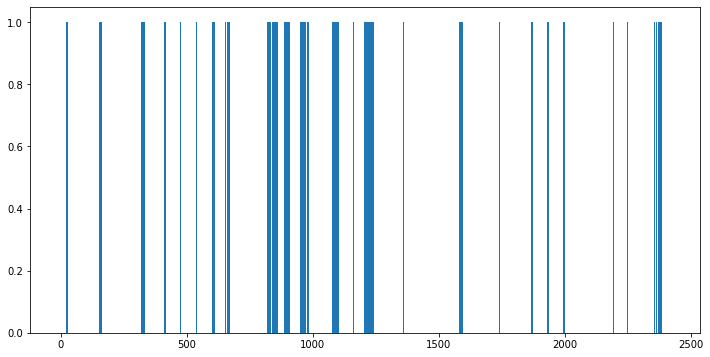

In [602]:
plt.rcParams['figure.figsize'] = [12, 6]

kmeans = KMeans(2).fit_predict(V100.T)
plt.bar(np.arange(2414),kmeans)

KM = KMeans(2).fit(V100.T)
print(KM.score(V100.T))

-98.25770825198586


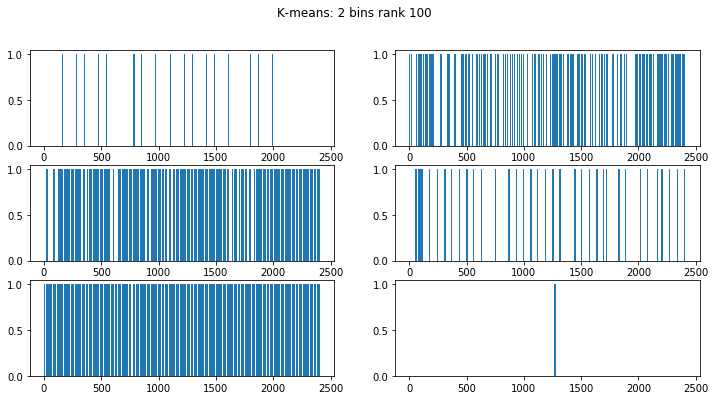

In [650]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('K-means: 2 bins rank 100')
ScoreKM100 = 0

for ii in range(3):
    kmeans = KMeans(2).fit_predict(V100.T)
    KM = KMeans(2).fit(V100.T)
    axs[ii,0].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)
    
    kmeans = KMeans(2).fit_predict(V100.T)
    KM = KMeans(2).fit(V100.T)
    axs[ii,1].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)

ScoreKM100 = (1/6)*ScoreKM100
print(ScoreKM100)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('K-means: 5 bins rank 100')
ScoreKM100 = 0

for ii in range(3):
    kmeans = KMeans(5).fit_predict(V100.T)
    KM = KMeans(5).fit(V100.T)
    axs[ii,0].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)
    
    kmeans = KMeans(5).fit_predict(V100.T)
    KM = KMeans(5).fit(V100.T)
    axs[ii,1].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)

ScoreKM100 = (1/6)*ScoreKM100
print(ScoreKM100)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('K-means: 10 bins rank 100')
ScoreKM100 = 0

for ii in range(3):
    kmeans = KMeans(10).fit_predict(V100.T)
    KM = KMeans(10).fit(V100.T)
    axs[ii,0].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)
    
    kmeans = KMeans(10).fit_predict(V100.T)
    KM = KMeans(10).fit(V100.T)
    axs[ii,1].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)

ScoreKM100 = (1/6)*ScoreKM100
print(ScoreKM100)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axs = plt.subplots(3,2)
fig.suptitle('K-means: 38 bins rank 100')
ScoreKM100 = 0

for ii in range(3):
    kmeans = KMeans(38).fit_predict(V100.T)
    KM = KMeans(38).fit(V100.T)
    axs[ii,0].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)
    
    kmeans = KMeans(38).fit_predict(V100.T)
    KM = KMeans(38).fit(V100.T)
    axs[ii,1].bar(np.arange(2414),kmeans)
    
    ScoreKM100 = ScoreKM100 + KM.score(V100.T)

ScoreKM100 = (1/6)*ScoreKM100
print(ScoreKM100)